In [1]:
import numpy as np
import pickle

from scipy.stats import spearmanr
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

# load explanations

In [2]:
#load explanations

#lime
method='lime'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']
n=3000

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_lime = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#kernelshap
method='kernelshap'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_kernelshap = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#vanillagrad
method='vanillagrad'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_vanillagrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#gradient*input
method='gradtinput'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_gradtinput = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#integrated gradients
method='integratedgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_integratedgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#smoothgrad
method='smoothgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_smoothgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


# calculate rank correlation

In [3]:
def calc_rank_corr_two_methods(attr1, attr2):
    '''
    attr1: np.array, n x p
    attr2: np.array, n x p
    '''
    #calculate rank correlation for each data point
    #https://stackoverflow.com/questions/44947030/how-to-get-scipy-stats-spearmanra-b-compute-correlation-only-between-variable
    corrs = []
    for row in range(attr1.shape[0]):
        rho, _ = spearmanr(np.abs(attr1[row, :]), np.abs(attr2[row, :]))
        corrs.append(rho)
        
    return corrs #rank correlations for each datapoint


In [4]:
def calc_rank_corr_all_methods(expl_methods_names, expl_methods_attrs):
    '''
    inputs
    expl_methods_names: dictionary with string names of explanation methods (keys=method_index, values=method_name_string)
    expl_methods_attrs: dictionary of attributions (keys=method_index, values=attributions for a model)
    
    outputs
    avg_corr_matrix: array with average rank correlation for each pair of methods
    corr_distr: dictionary with distribution of rank correlation for each method pair
    '''
    #initiate dict to store distribution of rank correlation for each method pair
    corr_distr = {}
    
    #initiate array to store average rank correlation for each method pair
    num_expl_methods = len(expl_methods_attrs)
    avg_corr_matrix = np.zeros([num_expl_methods, num_expl_methods])
    
    #fill corr_distr and avg_corr_matrix 
    for a, b in itertools.combinations_with_replacement(range(num_expl_methods), 2):
        #print(f'calculating {expl_methods_names[a]} ({a}) and {expl_methods_names[b]} ({b})')
        corrs = calc_rank_corr_two_methods(expl_methods_attrs[a], expl_methods_attrs[b]) #rank correlations for each datapoint
        #corr_distr
        
        if a != b:
            corr_distr[f'{expl_methods_names[a]} vs. {expl_methods_names[b]}'] = corrs
        #avg_corr_matrix
        avg_corr_matrix[a, b] = np.mean(corrs) 
        avg_corr_matrix[b, a] = avg_corr_matrix[a, b]
        
    return corr_distr, avg_corr_matrix
    

# calculate agreement fraction

In [5]:
#calculate topk agreement, two methods
def calc_topk_agreement_two_methods(attr1, attr2, k, topk_type=['strict', 'lessstrict', 'avgprop']):
    '''
    attr1: np.array, n x p
    attr2: np.array, n x p
    '''
    #get topk features
    topk1 = np.argsort(-np.abs(attr1), axis=1)[:, 0:k]
    topk2 = np.argsort(-np.abs(attr2), axis=1)[:, 0:k]
    
    if topk_type=='strict':
        #calculate proportion of points where the two explanations are an exact match (topk features: same features, same order)
        boolean_list = np.sum(topk1 == topk2, axis=1) == k #one datapoint = true or false
        metric = np.mean(boolean_list) #proportion of datapoints that meet criteria

    elif topk_type=='lessstrict':
        #calculate proportion of points where the 2 explanations have same features (topk features: same features, order does not matter)
        topk1_sets = [set(row) for row in topk1]
        topk2_sets = [set(row) for row in topk2]
        boolean_list = [setA == setB for setA, setB in zip(topk1_sets, topk2_sets)] #one datapoint = true or false
        metric = np.mean(boolean_list) #proportion of datapoints that meet criteria
        
    elif topk_type=='avgprop':
        #calculate average proportion of shared features among the 2 explanations' top k features        
        topk1_sets = [set(row) for row in topk1]
        topk2_sets = [set(row) for row in topk2]
        metric = [len(setA.intersection(setB))/k for setA, setB in zip(topk1_sets, topk2_sets)] #prop for one datapoint = (#topk features in common)/k
        #metric = np.mean(np.array(prop_common_list)) #average proportion agreement among topk features over all datapoints

    return metric


In [6]:
#calculate topk agreement, all methods
def calc_topk_agreement_all_methods_by_k(expl_methods_names, expl_methods_attrs, ks, topk_type=['strict', 'lessstrict', 'avgprop']):
    #initiate matrix
    num_expl_methods = len(expl_methods_attrs)
    
    #fill matrix with pairwise topk agreement
    metrics_dict = {}
    for a, b in itertools.combinations(range(num_expl_methods), 2):
        metrics_list = []
        for k in ks:
            topk_metric = calc_topk_agreement_two_methods(expl_methods_attrs[a], expl_methods_attrs[b], k, topk_type)
            metrics_list.append(topk_metric)
        metrics_dict[f'{expl_methods_names[a]} vs. {expl_methods_names[b]}'] = metrics_list
            
    return metrics_dict



# plotting function

In [7]:
#plot rank correlation and agreement fraction side-by-side

def plot_rankcorr_agreemtfrac(expl_methods_names, expl_methods_attrs, k, plot_path):
    
    #calculate rank correlation
    corr_distr, avg_corr_matrix = calc_rank_corr_all_methods(expl_methods_names, expl_methods_attrs)

    #calculate agreement fraction
    metrics_dict = calc_topk_agreement_all_methods_by_k(expl_methods_names, expl_methods_attrs, ks=[k], topk_type='avgprop')

    #plot
    fig, axes = plt.subplots(1, 2, figsize =(10, 3))
    #rank corr
    i=0
    sns.boxplot(data=list(corr_distr.values()), color='cornflowerblue', ax=axes[i])
    axes[i].set_xticklabels(list(corr_distr.keys()), rotation=90)
    axes[i].set(xlabel='Method pair', ylabel='Rank correlation');
    #agreement fraction
    i=1
    sns.violinplot(data=list(metrics_dict.values()), color='cornflowerblue', ax=axes[i], inner=None, cut=0, scale='count')
    axes[i].set(xlabel='Method pair', ylabel='Proportion of features shared', title=f'k = {k}')
    xlabels = list(metrics_dict.keys())
    axes[i].set_xticklabels(xlabels, rotation=0 if len(xlabels)==1 else 90);
    #save plot
    fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight')


    

# make plots

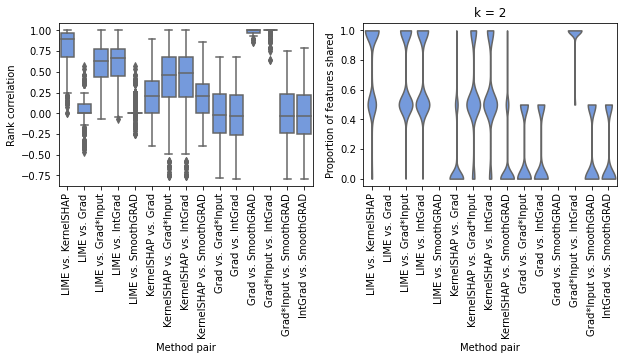

In [8]:
#neural network
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}

m='nn'

expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m], 
                          2: attr_vanillagrad[m],
                          3: attr_gradtinput[m],
                          4: attr_integratedgrad[m],
                          5: attr_smoothgrad[m]}

k=2

plot_path = f'figures/rankcorr_agreemtfrac_{m}.png'

plot_rankcorr_agreemtfrac(expl_methods_names, expl_methods_attrs, k, plot_path)


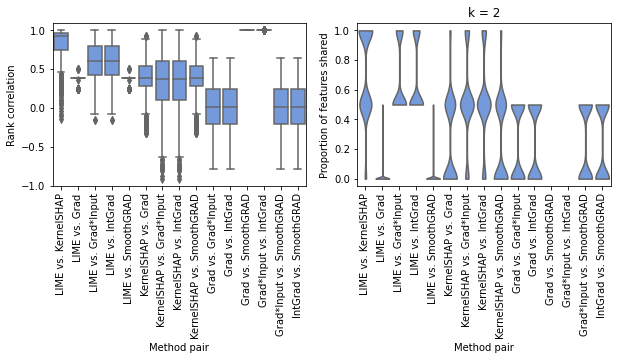

In [9]:
#logistic regression
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}

m='nn_logistic'

expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m], 
                          2: attr_vanillagrad[m],
                          3: attr_gradtinput[m],
                          4: attr_integratedgrad[m],
                          5: attr_smoothgrad[m]}

k=2

plot_path = f'figures/rankcorr_agreemtfrac_{m}.png'

plot_rankcorr_agreemtfrac(expl_methods_names, expl_methods_attrs, k, plot_path)
